# LSTM & Bidirectional LSTM

## Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers



In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Reading the data and doing preproccesing

In [4]:
# Read the data files:

train = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/train.csv")
valid = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/valid.csv")
test = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/test.csv")

# The balanced training set
train_balanced = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/train_balanced.csv")

In [5]:
le = LabelEncoder()


numeric_labels = le.fit_transform(train["Sentiment"])
Y_train = to_categorical(le.fit_transform(train["Sentiment"]))
Y_valid = to_categorical(le.fit_transform(valid["Sentiment"]))
Y_test = to_categorical(le.fit_transform(test["Sentiment"]))

le_balanced = LabelEncoder()
Y_train_balanced = to_categorical(le_balanced.fit_transform(train_balanced["Sentiment"]))

In [6]:
le_balanced.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [7]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [8]:
Y_valid

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [9]:
num_classes = 3

In [10]:
np.unique(train.Sentiment)

array(['negative', 'neutral', 'positive'], dtype=object)

# Setting up the vecotrization etc

In [ ]:
encoding = tf.keras.layers.TextVectorization(max_tokens = 1000)

# Creating the vocabulary using the adapt method.
encoding.adapt(train["Sentence"].values)

In [13]:
len(encoding.get_vocabulary())

1000

In [14]:
encoding.get_vocabulary()

['',
 '[UNK]',
 'the',
 'of',
 'in',
 'and',
 'to',
 'a',
 'for',
 's',
 'eur',
 'is',
 'company',
 'will',
 'from',
 'on',
 'its',
 'has',
 'said',
 'with',
 'be',
 'by',
 'finnish',
 'mn',
 'as',
 'it',
 'at',
 'sales',
 'million',
 'that',
 'net',
 'profit',
 'was',
 'an',
 'group',
 'finland',
 'year',
 'are',
 'operating',
 'mln',
 '2008',
 '2009',
 'business',
 'm',
 'period',
 '2007',
 'new',
 'oyj',
 'also',
 'which',
 'share',
 '2010',
 'services',
 'quarter',
 'market',
 'have',
 'shares',
 'first',
 'this',
 'up',
 'helsinki',
 'been',
 'euro',
 '2006',
 'financial',
 'loss',
 'contract',
 'about',
 'compared',
 'per',
 'bank',
 'we',
 'production',
 'today',
 'percent',
 'operations',
 'according',
 'total',
 'nokia',
 'mobile',
 'were',
 'hel',
 'corporation',
 'than',
 'service',
 'our',
 'corresponding',
 'companies',
 'solutions',
 'pct',
 'products',
 'other',
 'investment',
 'customers',
 'technology',
 'agreement',
 'some',
 'construction',
 'rose',
 'order',
 'plant

# Defining functions for visualization and creating different models

In [15]:
def lstm_model(dropout = False, rate = 0.5, 
               embed_dim = 10, num_layers = 1, lstm_units = 64,
              more_dropout = False):
    
    model = keras.Sequential()
    model.add(encoding)

    model.add(keras.layers.Embedding(
        input_dim = encoding.vocabulary_size(),
        output_dim = embed_dim,
        mask_zero = True))
    if more_dropout:
        model.add(tf.keras.layers.Dropout(rate = rate))
        
    model.add(tf.keras.layers.LSTM(lstm_units))
    if more_dropout:
        model.add(tf.keras.layers.Dropout(rate = rate))    
    
    for i in range(num_layers):
        model.add(keras.layers.Dense(64, activation = "relu"))
        if dropout:
            model.add(tf.keras.layers.Dropout(rate = rate))
    model.add(keras.layers.Dense(num_classes, activation = "softmax"))


    model.compile(optimizer = Adam(learning_rate = 0.01,), metrics = ['accuracy'], loss = CategoricalCrossentropy())
    return model

In [16]:
def predictions_func(model_input):
    predictions = model_input.predict(test["Sentence"].values)
    predictions2 = le.inverse_transform(np.argmax(predictions, axis = 1))
    print(classification_report(test["Sentiment"].values, predictions2))
    
    cm = confusion_matrix(test["Sentiment"].values, predictions2)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)
    disp.plot()

In [17]:
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Fitting models

## Trying out LSTM models

In [18]:
lstm_1 = lstm_model()
lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 10)          10000     
                                                                 
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 33,555
Trainable params: 33,555
Non-trainable params: 0
____________________________________________________

In [ ]:
lstm_fit1 = lstm_1.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 100, validation_data = (valid["Sentence"].values, Y_valid))

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.55      0.54      0.54       119
     neutral       0.78      0.79      0.78       575
    positive       0.63      0.62      0.62       276

    accuracy                           0.71       970
   macro avg       0.65      0.65      0.65       970
weighted avg       0.71      0.71      0.71       970



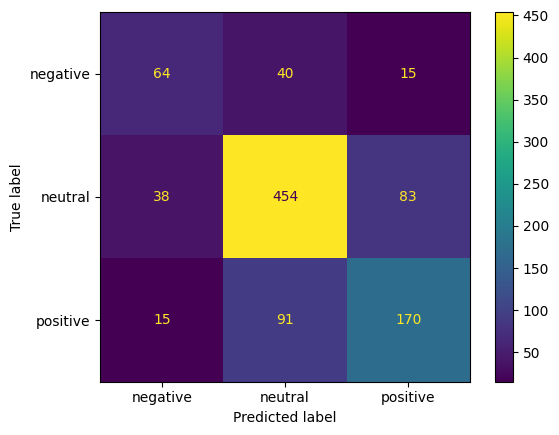

In [20]:
predictions_func(lstm_1)

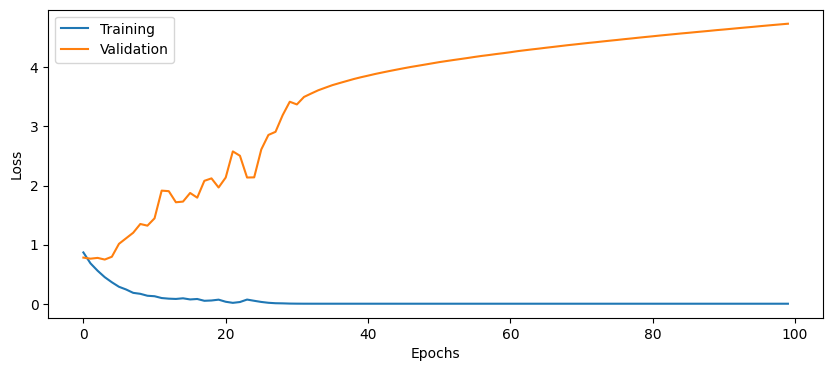

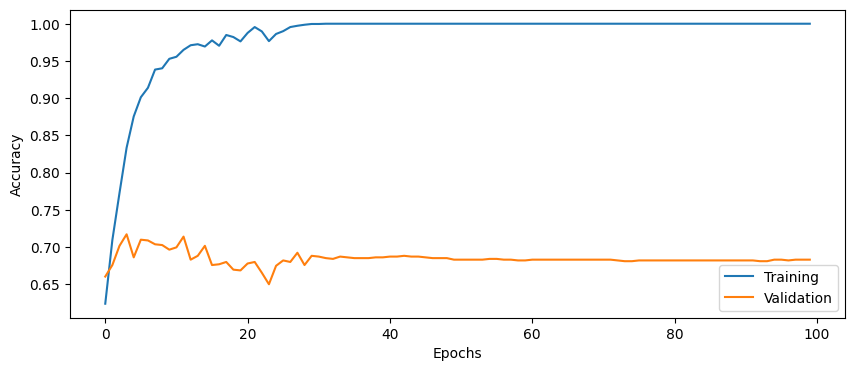

In [22]:
plot_results(lstm_fit1)

In [23]:
lstm_2 = lstm_model(embed_dim = 60)
lstm_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 60)          60000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                32000     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 96,355
Trainable params: 96,355
Non-trainable params: 0
__________________________________________________

In [24]:
lstm_fit2 = lstm_2.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 100, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/100
46/46 [==============================] - 6s 87ms/step - loss: 0.8552 - accuracy: 0.6319 - val_loss: 0.7590 - val_accuracy: 0.6636
Epoch 2/100
46/46 [==============================] - 2s 40ms/step - loss: 0.6508 - accuracy: 0.7334 - val_loss: 0.7109 - val_accuracy: 0.7276
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 0.4921 - accuracy: 0.8115 - val_loss: 0.7427 - val_accuracy: 0.7090
Epoch 4/100
46/46 [==============================] - 1s 21ms/step - loss: 0.3627 - accuracy: 0.8655 - val_loss: 0.8480 - val_accuracy: 0.6956
Epoch 5/100
46/46 [==============================] - 1s 19ms/step - loss: 0.2939 - accuracy: 0.8913 - val_loss: 0.9510 - val_accuracy: 0.7255
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 0.2309 - accuracy: 0.9140 - val_loss: 1.1869 - val_accuracy: 0.6832
Epoch 7/100
46/46 [==============================] - 1s 15ms/step - loss: 0.1609 - accuracy: 0.9419 - val_loss: 1.2419 - val_accuracy: 0.6770
Epoch 

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.61      0.55      0.58       119
     neutral       0.75      0.81      0.78       575
    positive       0.64      0.56      0.60       276

    accuracy                           0.71       970
   macro avg       0.67      0.64      0.65       970
weighted avg       0.70      0.71      0.70       970



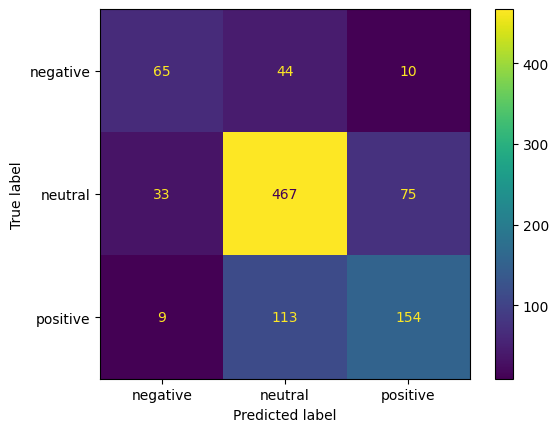

In [25]:
predictions_func(lstm_2)

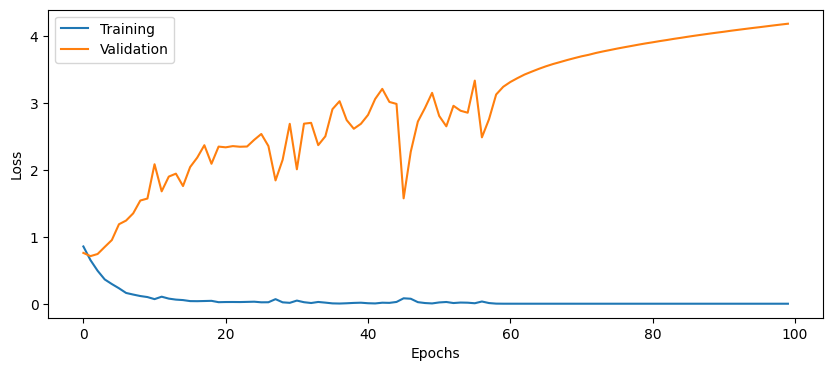

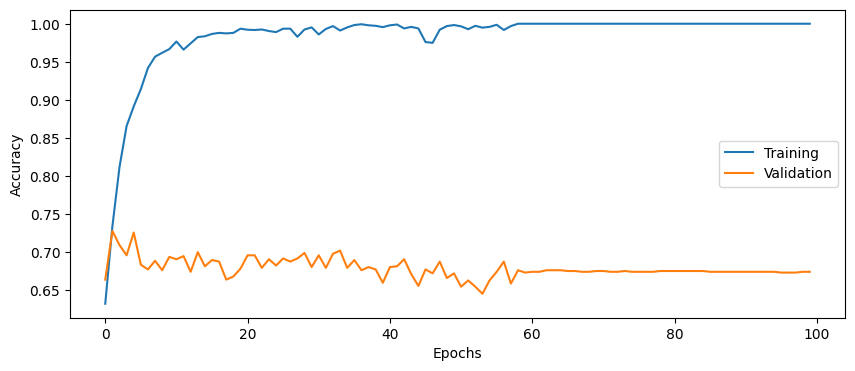

In [27]:
plot_results(lstm_fit2)

In [28]:
lstm_3 = lstm_model(lstm_units = 32)
lstm_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 10)          10000     
                                                                 
 lstm_2 (LSTM)               (None, 32)                5504      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17,811
Trainable params: 17,811
Non-trainable params: 0
__________________________________________________

In [29]:
lstm_fit3 = lstm_3.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 100, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/100
46/46 [==============================] - 5s 63ms/step - loss: 0.8893 - accuracy: 0.6054 - val_loss: 0.7501 - val_accuracy: 0.6729
Epoch 2/100
46/46 [==============================] - 1s 31ms/step - loss: 0.6859 - accuracy: 0.7152 - val_loss: 0.8130 - val_accuracy: 0.6192
Epoch 3/100
46/46 [==============================] - 1s 19ms/step - loss: 0.5848 - accuracy: 0.7578 - val_loss: 0.7186 - val_accuracy: 0.6997
Epoch 4/100
46/46 [==============================] - 1s 18ms/step - loss: 0.4608 - accuracy: 0.8277 - val_loss: 0.7809 - val_accuracy: 0.7018
Epoch 5/100
46/46 [==============================] - 1s 15ms/step - loss: 0.3889 - accuracy: 0.8579 - val_loss: 0.7572 - val_accuracy: 0.7141
Epoch 6/100
46/46 [==============================] - 1s 15ms/step - loss: 0.3093 - accuracy: 0.8930 - val_loss: 0.8801 - val_accuracy: 0.7162
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: 0.2736 - accuracy: 0.9009 - val_loss: 1.1276 - val_accuracy: 0.6760
Epoch 

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.56      0.55      0.55       119
     neutral       0.76      0.76      0.76       575
    positive       0.59      0.59      0.59       276

    accuracy                           0.69       970
   macro avg       0.63      0.63      0.63       970
weighted avg       0.69      0.69      0.69       970



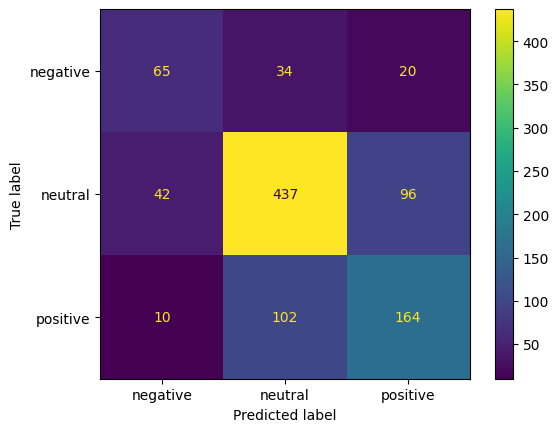

In [30]:
predictions_func(lstm_3)

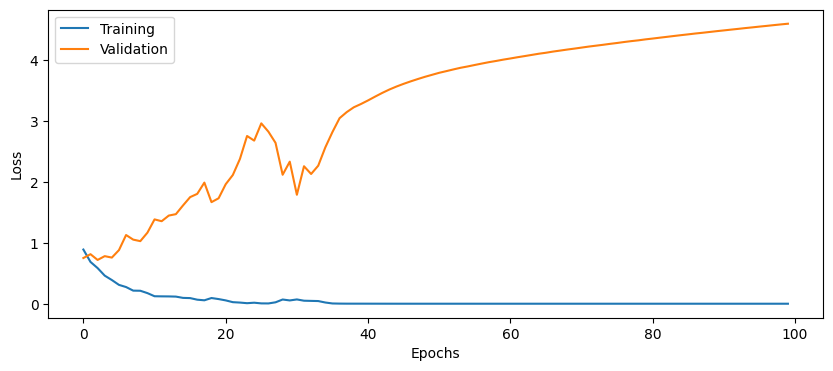

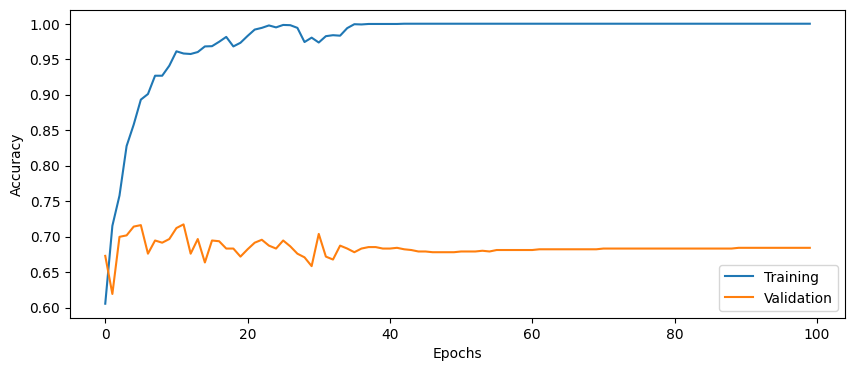

In [31]:
plot_results(lstm_fit3)

In [32]:
lstm_4 = lstm_model(lstm_units = 10)
lstm_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 10)          10000     
                                                                 
 lstm_3 (LSTM)               (None, 10)                840       
                                                                 
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 11,739
Trainable params: 11,739
Non-trainable params: 0
__________________________________________________

In [33]:
lstm_fit4 = lstm_4.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 100, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/100
46/46 [==============================] - 5s 65ms/step - loss: 0.8798 - accuracy: 0.6068 - val_loss: 0.7639 - val_accuracy: 0.6770
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.6873 - accuracy: 0.7062 - val_loss: 0.7382 - val_accuracy: 0.6687
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.5698 - accuracy: 0.7750 - val_loss: 0.7461 - val_accuracy: 0.6770
Epoch 4/100
46/46 [==============================] - 1s 17ms/step - loss: 0.4516 - accuracy: 0.8311 - val_loss: 0.7168 - val_accuracy: 0.7100
Epoch 5/100
46/46 [==============================] - 1s 15ms/step - loss: 0.3479 - accuracy: 0.8799 - val_loss: 0.8356 - val_accuracy: 0.6749
Epoch 6/100
46/46 [==============================] - 0s 9ms/step - loss: 0.2870 - accuracy: 0.8982 - val_loss: 0.8644 - val_accuracy: 0.7131
Epoch 7/100
46/46 [==============================] - 1s 17ms/step - loss: 0.2210 - accuracy: 0.9254 - val_loss: 1.0080 - val_accuracy: 0.6904
Epoch 8

Epoch 59/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0268 - accuracy: 0.9921 - val_loss: 2.3965 - val_accuracy: 0.6533
Epoch 60/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0057 - accuracy: 0.9986 - val_loss: 2.8848 - val_accuracy: 0.6636
Epoch 61/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 2.9987 - val_accuracy: 0.6873
Epoch 62/100
46/46 [==============================] - 0s 10ms/step - loss: 5.6048e-04 - accuracy: 1.0000 - val_loss: 3.1131 - val_accuracy: 0.6811
Epoch 63/100
46/46 [==============================] - 0s 6ms/step - loss: 3.3012e-04 - accuracy: 1.0000 - val_loss: 3.1993 - val_accuracy: 0.6821
Epoch 64/100
46/46 [==============================] - 0s 6ms/step - loss: 2.5669e-04 - accuracy: 1.0000 - val_loss: 3.2700 - val_accuracy: 0.6842
Epoch 65/100
46/46 [==============================] - 0s 6ms/step - loss: 2.1216e-04 - accuracy: 1.0000 - val_loss: 3.3290 - val_accura

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.52      0.51      0.52       119
     neutral       0.76      0.77      0.77       575
    positive       0.60      0.60      0.60       276

    accuracy                           0.69       970
   macro avg       0.63      0.63      0.63       970
weighted avg       0.69      0.69      0.69       970



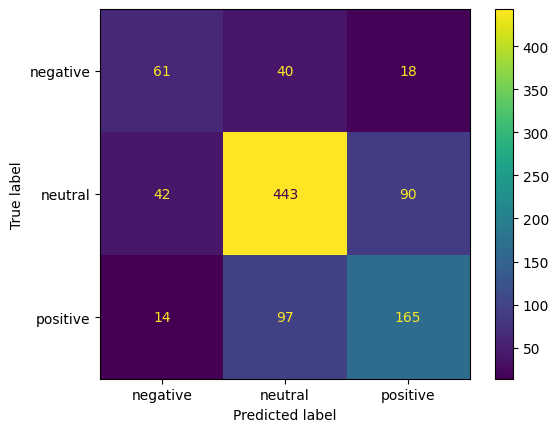

In [34]:
predictions_func(lstm_4)

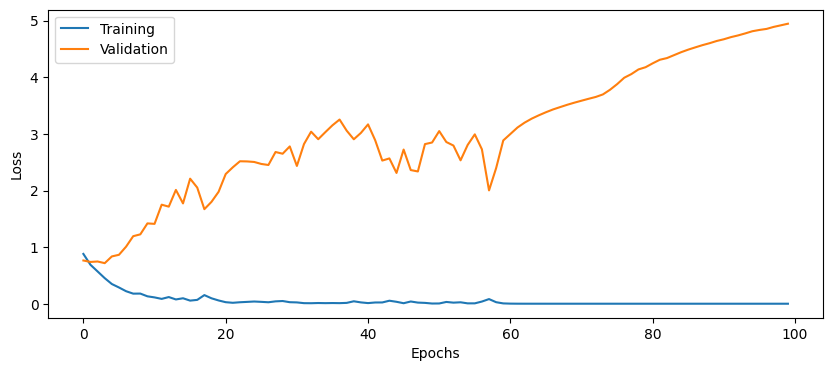

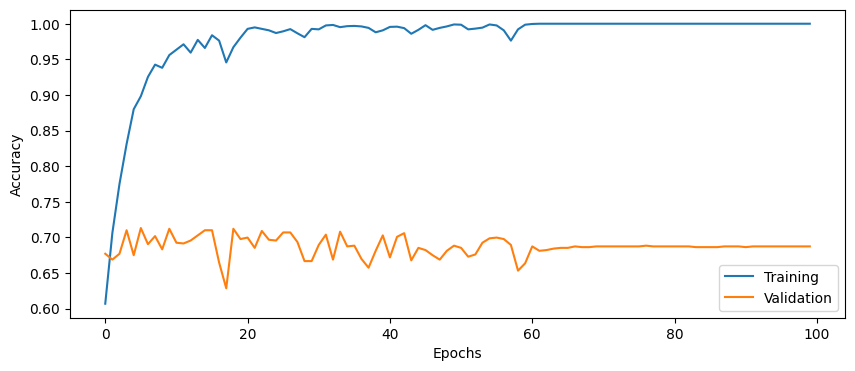

In [35]:
plot_results(lstm_fit4)

### Short analysis

Very prone to overiftting, training more than 40 epochs seems unneccesary.

Using a vocabulary size = 1000 results in a lot of over fitting. The training accuracy reaches 1 and the validation accuracy converges to around 70. Furthermore, the recall / precision for the smaller classes does not seem to improve a lot.



### Adding dropout after embedding and LSTM layer

In [36]:
#def lstm_model(dropout = False, rate = 0.5, 
        #       embed_dim = 10, num_layers = 1, lstm_units = 64,
        #      more_dropout = False):

In [37]:
lstm_5 = lstm_model(more_dropout = True, lstm_units = 16)
lstm_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, None, 10)          10000     
                                                                 
 dropout (Dropout)           (None, None, 10)          0         
                                                                 
 lstm_4 (LSTM)               (None, 16)                1728      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                1088      
                                                      

In [38]:
lstm_fit5 = lstm_5.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 50, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/50
46/46 [==============================] - 5s 65ms/step - loss: 0.8980 - accuracy: 0.5982 - val_loss: 0.7640 - val_accuracy: 0.6718
Epoch 2/50
46/46 [==============================] - 1s 30ms/step - loss: 0.7481 - accuracy: 0.6732 - val_loss: 0.7626 - val_accuracy: 0.6821
Epoch 3/50
46/46 [==============================] - 1s 18ms/step - loss: 0.6943 - accuracy: 0.7083 - val_loss: 0.7225 - val_accuracy: 0.6760
Epoch 4/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6569 - accuracy: 0.7355 - val_loss: 0.7472 - val_accuracy: 0.6832
Epoch 5/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6145 - accuracy: 0.7355 - val_loss: 0.7324 - val_accuracy: 0.6646
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6089 - accuracy: 0.7358 - val_loss: 0.7196 - val_accuracy: 0.6780
Epoch 7/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5906 - accuracy: 0.7492 - val_loss: 0.7746 - val_accuracy: 0.6873
Epoch 8/50
46/

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.64      0.49      0.56       119
     neutral       0.77      0.83      0.80       575
    positive       0.64      0.58      0.61       276

    accuracy                           0.72       970
   macro avg       0.68      0.64      0.65       970
weighted avg       0.71      0.72      0.71       970



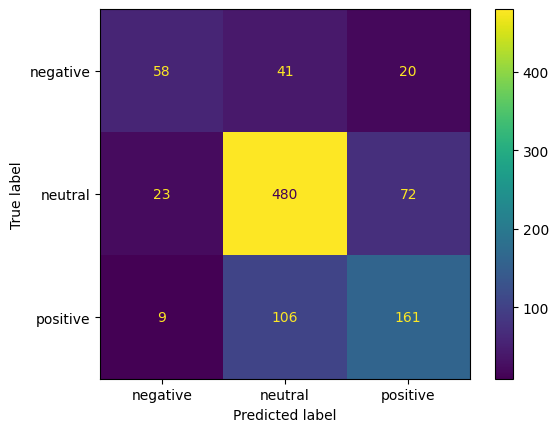

In [39]:
predictions_func(lstm_5)

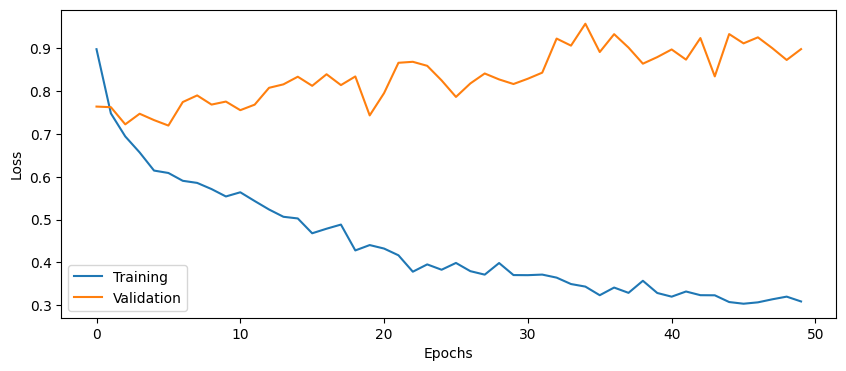

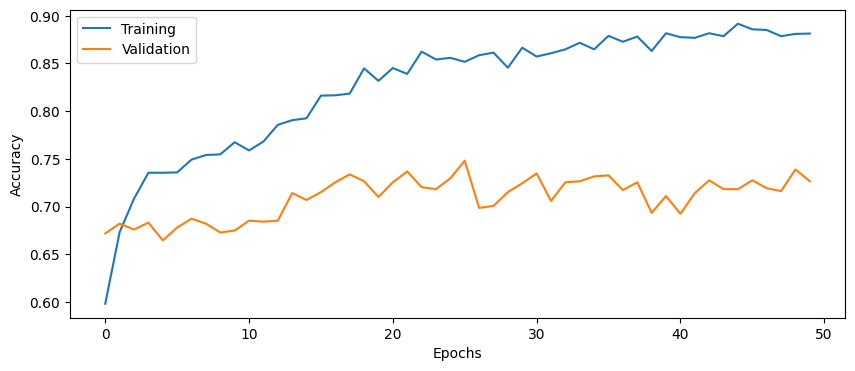

In [40]:
plot_results(lstm_fit5)

## Training LSTM models on the balanced data to see if it improves the results

Here, I am reusing the same the same model structure that resulted in best peformance with unbalanced training data. RUnning same experiment but with balanced training.

In [41]:
lstm_1_balanced = lstm_model(more_dropout = True, lstm_units = 16)
lstm_1_balanced.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, None, 10)          10000     
                                                                 
 dropout_2 (Dropout)         (None, None, 10)          0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                1728      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                1088      
                                                      

In [42]:
lstm1_balance_fit = lstm_1_balanced.fit(x = train_balanced["Sentences"].values, y = Y_train_balanced, 
                    batch_size = 64, epochs = 50, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/50
81/81 [==============================] - 6s 52ms/step - loss: 0.9866 - accuracy: 0.4731 - val_loss: 0.7673 - val_accuracy: 0.6615
Epoch 2/50
81/81 [==============================] - 1s 18ms/step - loss: 0.7429 - accuracy: 0.6690 - val_loss: 0.7477 - val_accuracy: 0.6935
Epoch 3/50
81/81 [==============================] - 1s 14ms/step - loss: 0.5858 - accuracy: 0.7666 - val_loss: 0.7294 - val_accuracy: 0.6945
Epoch 4/50
81/81 [==============================] - 1s 9ms/step - loss: 0.5130 - accuracy: 0.8037 - val_loss: 0.8178 - val_accuracy: 0.6770
Epoch 5/50
81/81 [==============================] - 1s 8ms/step - loss: 0.4714 - accuracy: 0.8214 - val_loss: 0.8245 - val_accuracy: 0.6956
Epoch 6/50
81/81 [==============================] - 1s 11ms/step - loss: 0.4676 - accuracy: 0.8243 - val_loss: 0.8234 - val_accuracy: 0.6739
Epoch 7/50
81/81 [==============================] - 1s 8ms/step - loss: 0.4345 - accuracy: 0.8398 - val_loss: 0.7422 - val_accuracy: 0.7172
Epoch 8/50
81/81

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.50      0.61      0.55       119
     neutral       0.78      0.81      0.80       575
    positive       0.65      0.55      0.59       276

    accuracy                           0.71       970
   macro avg       0.65      0.65      0.65       970
weighted avg       0.71      0.71      0.71       970



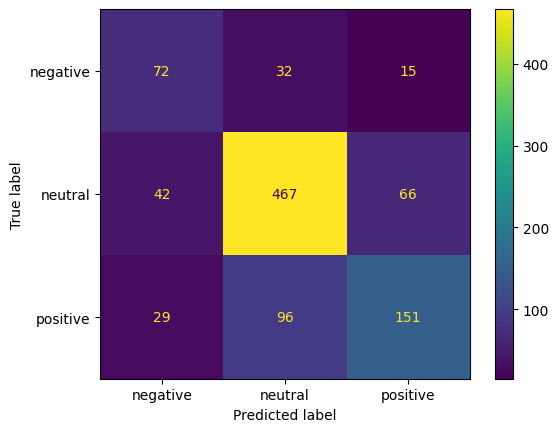

In [43]:
predictions_func(lstm_1_balanced)

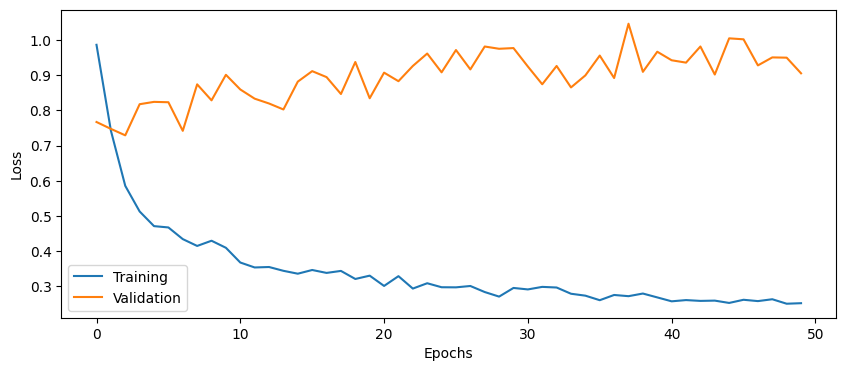

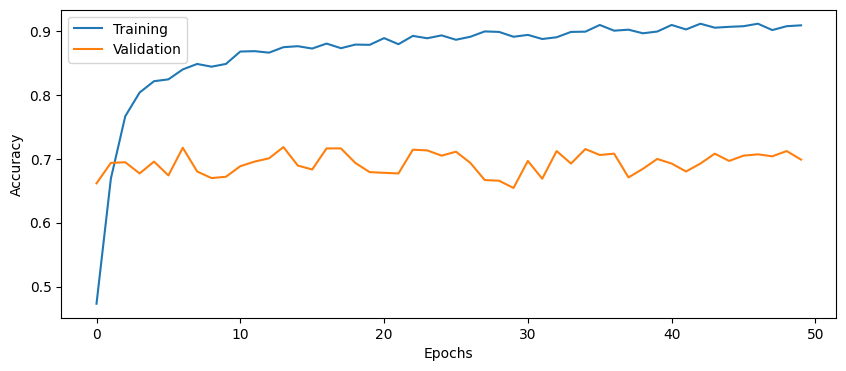

In [44]:
plot_results(lstm1_balance_fit)

## Increasing the vocabulary size and the embedding size

In [45]:
encoding = tf.keras.layers.TextVectorization(max_tokens = 100000)
encoding.adapt(train["Sentence"].values)

### Using the same model that I thought was the best previously

In [46]:
lstm_6 = lstm_model(embed_dim = 100, more_dropout = True, lstm_units = 32, rate = 0.7)
lstm_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, None, 100)         851100    
                                                                 
 dropout_4 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                      

In [47]:
lstm_fit6 = lstm_6.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 10, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/10
46/46 [==============================] - 7s 101ms/step - loss: 0.8854 - accuracy: 0.6030 - val_loss: 0.7281 - val_accuracy: 0.6863
Epoch 2/10
46/46 [==============================] - 3s 56ms/step - loss: 0.6529 - accuracy: 0.7307 - val_loss: 0.7191 - val_accuracy: 0.6904
Epoch 3/10
46/46 [==============================] - 2s 47ms/step - loss: 0.4537 - accuracy: 0.8105 - val_loss: 0.8251 - val_accuracy: 0.7121
Epoch 4/10
46/46 [==============================] - 1s 31ms/step - loss: 0.3546 - accuracy: 0.8669 - val_loss: 1.0659 - val_accuracy: 0.7059
Epoch 5/10
46/46 [==============================] - 1s 27ms/step - loss: 0.2457 - accuracy: 0.9154 - val_loss: 0.9912 - val_accuracy: 0.7245
Epoch 6/10
46/46 [==============================] - 1s 29ms/step - loss: 0.1650 - accuracy: 0.9474 - val_loss: 1.1834 - val_accuracy: 0.7482
Epoch 7/10
46/46 [==============================] - 1s 20ms/step - loss: 0.1316 - accuracy: 0.9622 - val_loss: 1.2712 - val_accuracy: 0.7348
Epoch 8/10
4

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.64      0.61      0.62       119
     neutral       0.81      0.80      0.80       575
    positive       0.61      0.64      0.63       276

    accuracy                           0.73       970
   macro avg       0.69      0.68      0.69       970
weighted avg       0.73      0.73      0.73       970



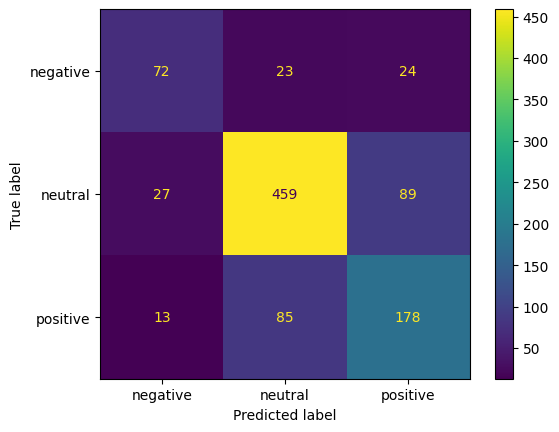

In [48]:
predictions_func(lstm_6)

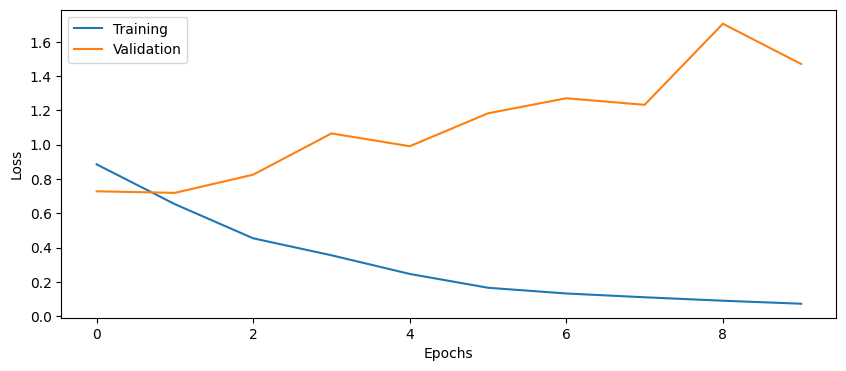

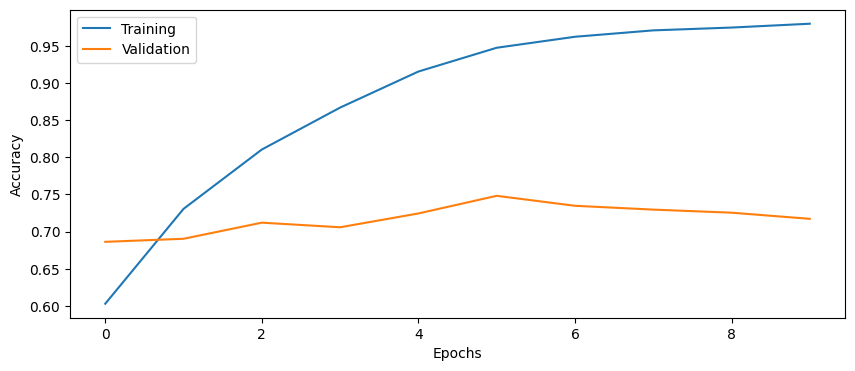

In [49]:
plot_results(lstm_fit6)

### Using the same embedding size and vocabulary size on balanced data.

In [50]:
lstm_7 = lstm_model(embed_dim = 100, more_dropout = True, lstm_units = 32, rate = 0.7)
lstm_7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, None, 100)         851100    
                                                                 
 dropout_6 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                      

In [51]:
lstm_fit7 = lstm_7.fit(x = train_balanced["Sentences"].values, y = Y_train_balanced,
                    batch_size = 64, epochs = 10, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/10
81/81 [==============================] - 7s 59ms/step - loss: 0.7528 - accuracy: 0.6577 - val_loss: 0.6721 - val_accuracy: 0.7523
Epoch 2/10
81/81 [==============================] - 3s 34ms/step - loss: 0.3596 - accuracy: 0.8826 - val_loss: 0.8451 - val_accuracy: 0.7337
Epoch 3/10
81/81 [==============================] - 3s 35ms/step - loss: 0.1809 - accuracy: 0.9489 - val_loss: 1.0507 - val_accuracy: 0.7430
Epoch 4/10
81/81 [==============================] - 2s 21ms/step - loss: 0.1304 - accuracy: 0.9603 - val_loss: 1.2688 - val_accuracy: 0.7337
Epoch 5/10
81/81 [==============================] - 1s 11ms/step - loss: 0.0893 - accuracy: 0.9745 - val_loss: 1.2875 - val_accuracy: 0.7451
Epoch 6/10
81/81 [==============================] - 1s 14ms/step - loss: 0.0582 - accuracy: 0.9821 - val_loss: 1.5161 - val_accuracy: 0.7420
Epoch 7/10
81/81 [==============================] - 1s 12ms/step - loss: 0.0534 - accuracy: 0.9854 - val_loss: 1.4055 - val_accuracy: 0.7265
Epoch 8/10
81

31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.69      0.66      0.67       119
     neutral       0.78      0.80      0.79       575
    positive       0.62      0.61      0.61       276

    accuracy                           0.73       970
   macro avg       0.70      0.69      0.69       970
weighted avg       0.72      0.73      0.73       970



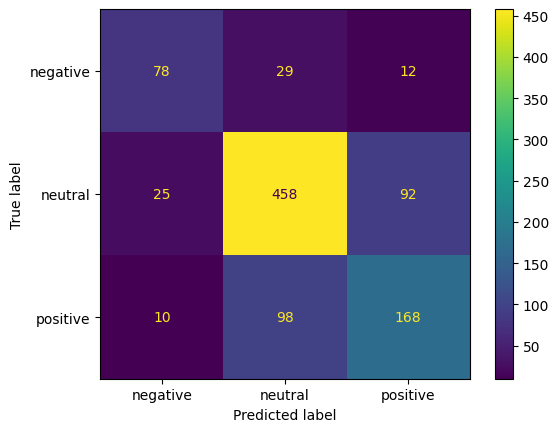

In [52]:
predictions_func(lstm_7)

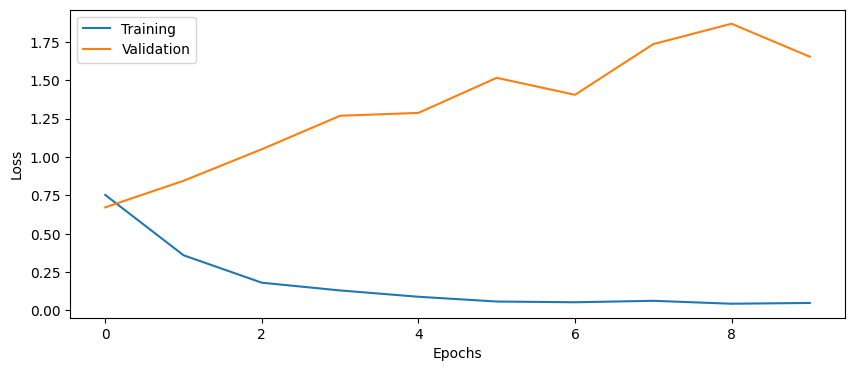

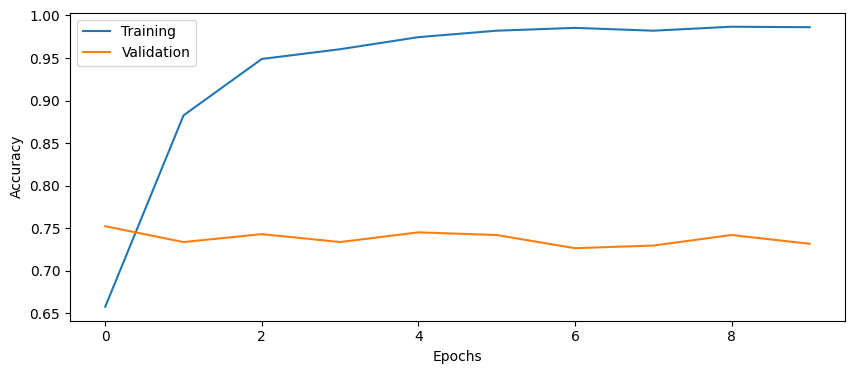

In [53]:
plot_results(lstm_fit7)

# Summary

All models seem prone to overfitting. Using dropout did not solve this issue (and also other techniques). How to deal with this? -> future studies.

Error analysis: Models seem to confuse the neutral phrases with positive ones. Data issue? How to solve this?

Increasing the vocabulary size by a large amount but also increasing the dimension of the embedding layer imrpoved the overall accuracy by 2 percentage points.



# Links used

https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

https://stackoverflow.com/questions/56227671/how-can-i-one-hot-encode-a-list-of-strings-with-keras

https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

https://scikit-learn.org/stable/modules/preprocessing_targets.html